In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [17]:
#function to climatology and anomaly for given variable
def component_fn(inp):
    bar = inp.mean('time')
    #clim = inp.groupby('time.month').mean('time')
    dash = inp - bar
    return bar, dash

In [18]:
def diff_T(T):
    dTdt = T.differentiate(coord = 'time',datetime_unit= 's')
    dTdx = T.differentiate('lon') / (110e3 * np.cos(T.lat * np.pi / 180))
    dTdy = T.differentiate('lat') / (110e3 )
    dTdz = (T[:,0] - T[:,-1])/float(T.level[-1])
    return dTdt[:,:-1], dTdx[:,:-1], dTdy[:,:-1], dTdz



def get_weights(INP):
    weights = INP.level
    #add a 0m surface layer
    wt=np.array([0.])
    for i in range(len(weights.values)):
        NW = 2*weights.values[i]-wt[i]
        wt = np.insert(wt,i+1,NW)
    thickness = wt[1:]-wt[:-1]
    thickness_DA = xr.DataArray(thickness, coords={'level': INP.level},
                 dims=['level'])
    return thickness_DA

def weighted_avg(inp, weights):
    avg=inp.weighted(weights).mean('level')
    return avg


def get_clim(dict_name):
    dict1={}
    #unpack dict, get climatology, repack
    for key in dict_name.keys():
        var = dict_name[key]
        var = var.groupby('time.month').mean('time')
        dict1[key] = var
    return dict1

In [19]:
ls ~


anaconda3/    Documents/    ECPLOT.png  new.sh     Templates/  test_out.nc
Desktop/      Downloads/    GPLOT.png   Pictures/  test1.nc    Videos/
diffPLOT.png  dzdt.1980.nc  Music/      Public/    test.nc


In [20]:
#now do the same for ec-earth3
T = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/THETAO/*.nc').thetao
U = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/UO/*.nc').uo
V = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/VO/*.nc').vo
#W = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/WO/*.nc').wo
Q = xr.open_mfdataset('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/HFDS/*.nc').hfds
#get only to 50m
T = T[:,:5]
U = U[:,:5]
V = V[:,:5]
#W = W[:,4]
#now put lat lon of uvw to T
U = U.assign_coords({'lat': T.lat, 'lon': T.lon})
V = V.assign_coords({'lat': T.lat, 'lon': T.lon})
#W = W.assign_coords({'lat': T.lat, 'lon': T.lon})
#rename lev coord to level
T = T.rename({'lev':'level'})
U = U.rename({'lev':'level'})
V = V.rename({'lev':'level'})
#W = W.rename({'lev':'level'})

In [21]:
#calculate W term
#first get dudx and dvdy
dudx = U.differentiate(coord = 'lon') / (110e3 * np.cos(U.lat * np.pi / 180))
dvdy = V.differentiate(coord='lat') / (110e3)


weights = U.level#add a 0m surface layer
wt=np.array([0.])
for i in range(len(weights.values)):
    NW = 2*weights.values[i]-wt[i]
    wt = np.insert(wt,i+1,NW)
thickness = wt[1:]-wt[:-1]
thickness_DA = xr.DataArray(thickness, coords={'level': U.level},
             dims=['level'])
w_list = []
print(thickness_DA.level)


for i, j in enumerate(thickness_DA):
    if i == 0:
        w = (dudx[:,i]*j + dvdy[:,i]*j)
        #add to new DataArray with vertical coords put in
        w = w.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
    else:
        l = (dudx[:,i]*j + dvdy[:,i]*j) + w_list[i-1]
        w = l.assign_coords({'level': thickness_DA.level[i]})
        w_list.append(w)
#now put all layers into one array
w = xr.concat(w_list, dim = 'level')
W = w
W = W[4,:]

<xarray.DataArray 'level' (level: 5)>
array([ 5., 15., 25., 35., 45.])
Coordinates:
  * level    (level) float64 5.0 15.0 25.0 35.0 45.0
Attributes:
    standard_name:  depth
    long_name:      ocean depth coordinate
    units:          m
    positive:       down
    axis:           Z
    bounds:         lev_bnds


In [22]:
dTdt, dTdx, dTdy, dTdz = diff_T(T)

In [23]:
#calcualte components for dT
dxc, dxd = component_fn(dTdx)
dyc, dyd = component_fn(dTdy)
dzc, dzd = component_fn(dTdz)

In [24]:
dxc*dxd

,Array,Chunk
Bytes,4.11 GB,248.83 MB
Shape,"(4, 180, 360, 1980)","(4, 180, 360, 120)"
Count,266 Tasks,17 Chunks
Type,float64,numpy.ndarray


In [25]:
dxc*dxd

,Array,Chunk
Bytes,4.11 GB,248.83 MB
Shape,"(4, 180, 360, 1980)","(4, 180, 360, 120)"
Count,266 Tasks,17 Chunks
Type,float64,numpy.ndarray


In [26]:
#calculate compenets of u,v,w
uc, ud = component_fn(U)
vc, vd = component_fn(V)
wc, wd = component_fn(W)

In [27]:
#now calculate 4 terms for each advection term/ Write function here so only need 3 lines for each
def adv_comp(CUR, DT):
    cc, cd = component_fn(CUR)
    dtc, dtz = component_fn(DT)
    ccdtc = cc*dtc
    ccdtz = dtz*cc
    cddtc = cd*dtc
    cddtz = cd*dtz
    return ccdtc, ccdtz, cddtc, cddtz   

In [28]:
ucdxc, ucdxd, uddxc, uddxd = adv_comp(U, dTdx)
vcdyc, vcdyd, vddyc, vddyd = adv_comp(V, dTdy)
wcdzc, wcdzd, wddzc, wddzd = adv_comp(W, dTdz)

In [29]:
#calculate weighted avergae of all terms
weights = get_weights(T)

ucdxc = weighted_avg(ucdxc, weights)
ucdxd = weighted_avg(ucdxd, weights)
uddxc = weighted_avg(uddxc, weights)
uddxd = weighted_avg(uddxd, weights)

vcdyc = weighted_avg(vcdyc, weights)
vcdyd = weighted_avg(vcdyd, weights)
vddyc = weighted_avg(vddyc, weights)
vddyd = weighted_avg(vddyd, weights)

In [30]:
#now get monthly climatology of these terms
ucdxd = ucdxd.groupby('time.month').mean('time')
uddxc = uddxc.groupby('time.month').mean('time')
uddxd = uddxd.groupby('time.month').mean('time')

vcdyd = vcdyd.groupby('time.month').mean('time')
vddyc = vddyc.groupby('time.month').mean('time')
vddyd = vddyd.groupby('time.month').mean('time')

wcdzd = wcdzd.groupby('time.month').mean('time')
wddzc = wddzc.groupby('time.month').mean('time')
wddzd = wddzd.groupby('time.month').mean('time')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


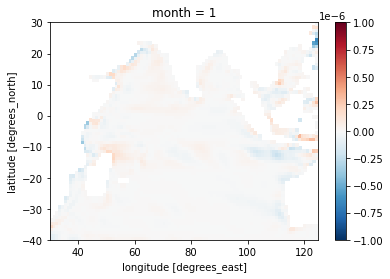

In [31]:
ucdxd.sel(lat=slice(-40,30),lon=slice(30,125))[0].plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


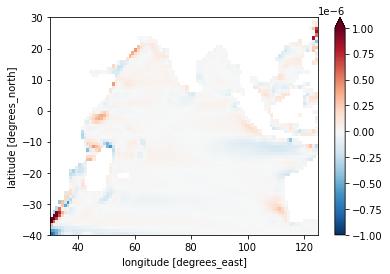

In [32]:
weighted_avg((uc*dxc), weights).sel(lat=slice(-40,30),lon=slice(30,125)).plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


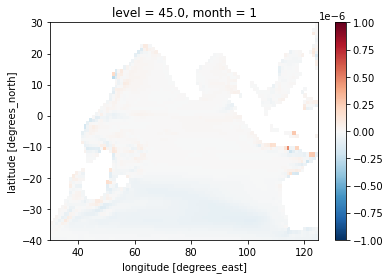

In [33]:
wcdzd.sel(lat=slice(-40,30),lon=slice(30,125))[0].plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')

In [35]:
#save these datasets
ucdxc.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_UbTb.nc')
ucdxd.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_UbTd.nc')
uddxc.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_UdTb.nc')
uddxd.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_UdTd.nc')

vcdyc.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_VbTb.nc')
vcdyd.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_VbTd.nc')
vddyc.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_VdTb.nc')
vddyd.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_VdTd.nc')

wcdzc.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_WbTb.nc')
wcdzd.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_WbTd.nc')
wddzc.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_WdTb.nc')
wddzd.to_netcdf('/home/z5113258/Documents/data/CMIP6/ACCESS-CM2/seasonal/EC_WdTd.nc')

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.

ValueError: dimensions or multi-index levels ['month'] do not exist

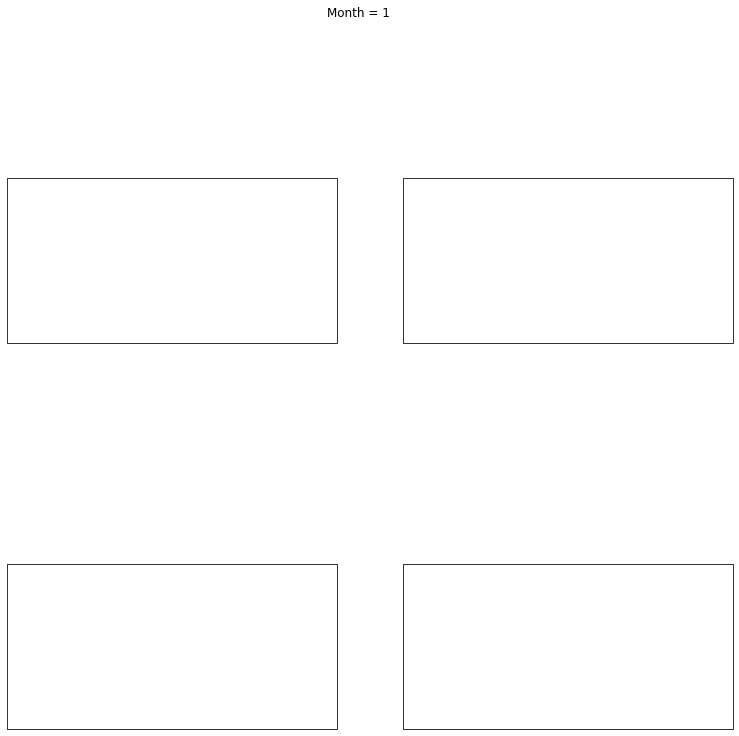

In [20]:
#lets create a plot for each month with each of the 4 advection components
lons = ucdxd.lon
lats = ucdxd.lat
def plot_background(ax, i, j):
    #for use with plotting 12 months. need to change 
    ax.set_extent([30., 125., -40., 30.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.LAND)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5,)
    gl.top_labels = False
    gl.right_labels = False
    if i == 1:
        gl.bottom_labels = True
    else:
        gl.bottom_labels = False
    if j > 0:
        gl.left_labels = False
    return ax
for i in range(0,1):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 13), sharey='all', sharex='all', 
                             subplot_kw={'projection':ccrs.PlateCarree()})
    mon = i+1
    fig.suptitle('Month = '+str(mon))
    #plot  advection term
    axes[0, 0].pcolormesh(lons, lats, ucdxc.sel(month = i+1), cmap = 'RdBu_r', 
                                vmin = -1E-7, vmax = 1E-7, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[0,0], 0, 0)
    axes[0,0].set_title('Ubar*dtdxbar')
    #
    im = axes[0, 1].pcolormesh(lons, lats, ucdxd.sel(month = i+1), cmap = 'RdBu_r', 
                                #colorbar=True, 
                                vmin = -1e-7, vmax = 1e-7, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[0,1], 0, 1)  
    axes[0,1].set_title("Ubar*dtdx'")

    fig.colorbar(im, ax = axes[0,1],format='%.0e')
    #plot difference
    im = axes[1, 0].pcolormesh(lons, lats, uddxc.sel(month = i+1), cmap = 'RdBu_r', 
                                #colorbar=True, 
                                vmin = -1e-7, vmax = 1e-7, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[1, 0], 1, 0)    
    fig.colorbar(im, ax = axes[1,0],format='%.0e')
    axes[1,0].set_title("U' dtdxbar")

    im = axes[1, 1].pcolormesh(lons, lats, uddxd.sel(month = i+1), cmap = 'RdBu_r', 
                                #colorbar=True, 
                                vmin = -1e-7, vmax = 1e-7, 
                                transform=ccrs.PlateCarree())
    plot_background(axes[1, 1], 1, 1)    
    fig.colorbar(im, ax = axes[1,1],format='%.0e')
    axes[1,1].set_title("U' dtdx'")

In [16]:
weights = get_weights(T)
dtdxw = weighted_avg(dTdx, weights)

In [17]:
#calculate dtbar and dt'
dtdxbar, dtdxd = test_fn(dtdxw)

NameError: name 'test_fn' is not defined

In [ ]:
(dtdxd.groupby('time.month').mean('time'))[5].plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')

In [ ]:
(dtdxd.groupby('time.month').mean('time'))[5].plot(vmin = -1e-6, vmax = 1e-6, cmap = 'RdBu_r')---------------------------------------------------------------------------

In [ ]:
dtdxd